# Notebook for the cell-cell interaction research of fetal stem cells with myeloid cells using liana package
- **Developed by:** Anna Maguza
- **Place:** Wuerzburg Institute for System Immunology
- **Date:** 20th November 2023

### Import required modules

In [1]:
import cell2cell as c2c
import liana as li

import decoupler as dc
import scanpy as sc

import plotnine as p9
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

from pycirclize import Circos

import torch

/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set up working environment

In [2]:
%matplotlib inline

In [3]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.3
scanpy      1.9.6
-----
Bio                         1.84
PIL                         10.1.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
brotli                      1.1.0
cell2cell                   0.7.4
certifi                     2023.11.17
cffi                        1.16.0
charset_normalizer          3.3.2
comm                        0.1.4
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
decoupler                   1.6.0
defusedxml                  0.7.1
docrep                      0.3.2
exceptiongroup              1.1.3
executing                   2.0.1
fastjsonschema              NA
fqdn                        NA
get_annotations             NA
h5py                        3.10.0
idna  

In [4]:
use_gpu = True

if use_gpu:
    import tensorly as tl
    tl.set_backend('pytorch')

In [5]:
torch.cuda.is_available()

True

In [6]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

### Data Upload

In [7]:
!pwd

/home/amaguza


In [8]:
adata = sc.read_h5ad('data/Fetal_cells_filtered_raw.h5ad')

In [9]:
X_is_raw(adata)

True

### Preprocess data

In [10]:
sc.pp.normalize_total(adata, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['ACTA2', 'ACTB', 'ACTG2', 'APOA1', 'APOA4', 'APOC3', 'B2M', 'CCK', 'CCL19', 'CCL21', 'CD69', 'CD74', 'CELA3B', 'CHGA', 'CLC', 'CLCA1', 'CLPS', 'COL1A1', 'COL1A2', 'COL3A1', 'CRYBA2', 'CST3', 'CXCL14', 'CXCL8', 'DEFA5', 'DEFA6', 'EEF1A1', 'FOS', 'FTH1', 'FTL', 'GAST', 'GCG', 'GHRL', 'GIP', 'GNLY', 'GUCA2A', 'GUCA2B', 'HBA1', 'HBA2', 'HBB', 'HBE1', 'HBG1', 'HBG2', 'HBM', 'HBZ', 'HSP90AA1', 'HSPA1A', 'HSPA6', 'HSPB1', 'INSL5', 'ITLN1', 'JCHAIN', 'LCN15', 'LYZ', 'MALAT1', 'MLN', 'MT-ATP6', 'MT-ATP8', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND1', 'MT-ND2', 'MT-ND3', 'MT-ND4', 'MT-ND4L', 'MT-ND6', 'MT1G', 'MT1H', 'MT2A', 'MTRNR2L12', 'NEAT1', 'NTS', 'PF4', 'PLA2G2A', 'PLCG2', 'PPBP', 'PPDPF', 'PPY', 'PRG2', 'PYY', 'RBP2', 'REG4', 'REN', 'S100A12', 'S100A8', 'S100A9', 'SPINK1', 'SPINK4', 'SPP1', 'SST', 'TAC1', 'TAGLN', 'TFF3', 'TMSB4X', 'TPSAB1', 'TTR', 'TXN2', 'ZG

* Extract stem cells and myeloid cells

In [11]:
myeloid = adata[adata.obs['Cell Type'] == 'Myeloid']

cell_states = []
for i in myeloid.obs['Cell States']:
    cell_states.append(i)
cell_states.append('FXYD3+_CKB+_SC')
cell_states.append('MTRNR2L12+ASS1+_SC')
cell_states.append('RPS10+_RPS17+_SC')

cell_states = list(cell_states)

adata = adata[adata.obs['Cell States'].isin(cell_states)]

In [12]:
adata = adata[adata.obs['Cell States'].map(adata.obs['Cell States'].value_counts() >= 10)]

### Liana Run

+ import all individual methods

In [13]:
sample_key = 'Donor_ID'
condition_key = 'Age_group'
groupby = 'Cell States'

In [14]:
li.mt.rank_aggregate.by_sample(adata,
                               sample_key=sample_key,
                               groupby=groupby,
                               resource_name = 'consensus',
                               expr_prop=0.1, # must be expressed in expr_prop fraction of cells
                               min_cells = 5,
                               n_perms = 100,
                               use_raw = False, # run on log- and library-normalized counts
                               verbose = True,
                               inplace = True,
                               return_all_lrs=True, # return all LR values
                              )

/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/sc/_Method.py:137: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
Now running: BRC2026:   0%|                           | 0/16 [00:00<?, ?it/s]/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/pandas/core/indexing.py:1857: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_pre.py:142: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/sc/_liana_pipe.py:246: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: Downcasting object dty

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/sc/_liana_pipe.py:246: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: Downcasting object dty

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/sc/_liana_pipe.py:246: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: Downcasting object dty

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/sc/_liana_pipe.py:246: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: Downcasting object dty

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/sc/_liana_pipe.py:246: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: Downcasting object dty

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/sc/_liana_pipe.py:246: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: Downcasting object dty

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/sc/_liana_pipe.py:246: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: Downcasting object dty

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/sc/_liana_pipe.py:246: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: Downcasting object dty

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/sc/_liana_pipe.py:246: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: Downcasting object dty

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/sc/_liana_pipe.py:246: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: Downcasting object dty

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/sc/_liana_pipe.py:246: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: Downcasting object dty

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/sc/_liana_pipe.py:246: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: Downcasting object dty

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/sc/_liana_pipe.py:246: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: Downcasting object dty

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/sc/_liana_pipe.py:246: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: Downcasting object dty

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/sc/_liana_pipe.py:246: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: Downcasting object dty

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/sc/_liana_pipe.py:246: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/amaguza/miniforge3/envs/liana_env/lib/python3.9/site-packages/liana/method/_pipe_utils/_reassemble_complexes.py:56: FutureWarning: Downcasting object dty

In [58]:
adata.write('data/FetalSC_and_myeloid_liana_aggregated_by_sample.h5ad')

### Create circus plot

In [15]:
interaction_data = adata.uns['liana_res']

+ leave only interactions with stem cells

In [16]:
interaction_data = interaction_data[interaction_data['source'].isin(['MTRNR2L12+ASS1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC']) | interaction_data['target'].isin(['MTRNR2L12+ASS1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC'])]

In [17]:
interaction_data['signalling'] = interaction_data['ligand_complex'] + '-' + interaction_data['receptor_complex']

/tmp/ipykernel_1623128/3664914360.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [51]:
top_20_unique_signalling = interaction_data.drop_duplicates(subset='signalling').sort_values(by='magnitude_rank', ascending=True).head(20)
top_20_unique_signalling_list = top_20_unique_signalling['signalling'].tolist()
print(top_20_unique_signalling_list)

['MIF-CD74_CXCR4', 'HMGB1-CXCR4', 'TIMP1-CD63', 'RPS19-C5AR1', 'APP-RPSA', 'MDK-NCL', 'C1QB-C1QBP', 'S100A4-ERBB3', 'HMGB1-CD163', 'HLA-B-CANX', 'LGALS1-ITGB1', 'HSP90AA1-ITGB3', 'MIF-CD44_CD74', 'HLA-A-APLP2', 'APP-CD74', 'AGTRAP-RACK1', 'B2M-LILRB2', 'COPA-CD74', 'APOA1-ABCA1', 'HMGB1-TLR4']


In [27]:
interaction_data.to_csv('data/FetalSC_and_myeloid_liana_aggregated_by_sample_interactions.csv')

In [19]:
palette= {  
    'LYVE1+ Macrophage':    '#FEEFC6',
    'MTRNR2L12+ASS1+_SC':   '#A3D8FF',
    'RPS10+_RPS17+_SC': '#E9A8F2',
    'FXYD3+_CKB+_SC':   '#97BE5A',
    'cDC2': '#FFAF7A',          
    'Monocytes':    '#DE8CBE',  
    'Macrophages':  '#1A9BFF',                                    
    'cDC1': '#43766C',
    'CLC+ Mast cell':   '#759EB8',
    'MPO+ mono-neutrophil': '#824670',
    'pDC':  '#FF76CE',
    'Megakaryocyte':    '#94FFD8',
    'Mast cell':    '#FFA27F'
    }   

In [19]:
interaction_data

,Donor_ID,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank,signalling
15,BRC2026,RPS10+_RPS17+_SC,cDC1,MIF,CD74_CXCR4,6.831882,0.0,41.563545,0.741582,1.692140,0.025317,0.905551,0.398815,0.0,0.000006,4.772758e-11,MIF-CD74_CXCR4
24,BRC2026,RPS10+_RPS17+_SC,pDC,MIF,CD74_CXCR4,6.490149,0.0,38.439354,0.641266,1.112556,0.023414,0.902156,0.382931,0.0,0.000009,2.448271e-10,MIF-CD74_CXCR4
26,BRC2026,RPS10+_RPS17+_SC,Macrophages,MIF,CD74_CXCR4,6.490053,0.0,38.438469,0.641237,1.451044,0.023414,0.902155,0.385966,0.0,0.000009,2.692909e-10,MIF-CD74_CXCR4
28,BRC2026,RPS10+_RPS17+_SC,cDC2,MIF,CD74_CXCR4,6.464173,0.0,38.201874,0.633640,1.228431,0.023270,0.901882,0.380763,0.0,0.000009,3.230005e-10,MIF-CD74_CXCR4
49,BRC2026,RPS10+_RPS17+_SC,Monocytes,MIF,CD74_CXCR4,6.066738,0.0,34.568424,0.516973,0.684303,0.021056,0.897370,0.363378,0.0,0.000013,2.699122e-09,MIF-CD74_CXCR4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3239930,F78,pDC,RPS10+_RPS17+_SC,ZG16B,CXCR4,0.566362,1.0,0.319823,-0.893448,-4.311391,0.001561,0.529418,0.000000,1.0,1.000000,1.000000e+00,ZG16B-CXCR4
3239934,F78,pDC,RPS10+_RPS17+_SC,ZG16B,TLR6,0.566362,1.0,0.319823,-0.893448,-4.311391,0.001561,0.529418,0.000000,1.0,1.000000,1.000000e+00,ZG16B-TLR6
3239935,F78,pDC,RPS10+_RPS17+_SC,ZP3,CHRNA7,0.566362,1.0,0.319823,-0.893448,-4.311391,0.001561,0.529418,0.000000,1.0,1.000000,1.000000e+00,ZP3-CHRNA7
3239936,F78,pDC,RPS10+_RPS17+_SC,ZP3,EGFR,0.566362,1.0,0.319823,-0.893448,-4.311391,0.001561,0.529418,0.000000,1.0,1.000000,1.000000e+00,ZP3-EGFR


In [28]:
MIF_CD74_CXCR4_data = interaction_data[interaction_data['signalling'] == 'MIF-CD74_CXCR4']

In [32]:
MIF_CD74_CXCR4_data = MIF_CD74_CXCR4_data[MIF_CD74_CXCR4_data['magnitude_rank'] != 1]

In [38]:
adata.uns['liana_res']

,Donor_ID,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
0,BRC2026,Monocytes,LYVE1+ Macrophage,S100A9,CD36,7.484985,0.0,55.317036,1.465968,3.763748,0.105376,0.917087,0.433107,0.0,2.647643e-08,9.715537e-15
1,BRC2026,MPO+ mono-neutrophil,LYVE1+ Macrophage,S100A9,CD36,7.201489,0.0,51.550190,1.381604,2.215807,0.098200,0.914366,0.428588,0.0,2.647643e-08,7.772380e-14
2,BRC2026,Monocytes,Monocytes,S100A9,ITGB2,7.171117,0.0,50.090252,1.370201,3.180967,0.089131,0.913234,0.417883,0.0,2.647643e-08,2.623162e-13
3,BRC2026,Monocytes,LYVE1+ Macrophage,S100A9,CD68,6.981726,0.0,46.936363,1.282247,3.185760,0.082206,0.910623,0.409988,0.0,2.647643e-08,2.098489e-12
4,BRC2026,MPO+ mono-neutrophil,Monocytes,S100A9,ITGB2,6.887621,0.0,46.679325,1.285837,1.633027,0.083062,0.910399,0.413407,0.0,7.742773e-08,2.819234e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3248857,F78,pDC,pDC,WNT9B,FZD5_LRP6,0.566362,1.0,0.319823,-0.893448,-4.311391,0.001561,0.529418,0.000000,1.0,1.000000e+00,1.000000e+00
3248858,F78,pDC,pDC,WNT9B,FZD6_LRP5,0.566362,1.0,0.319823,-0.893448,-4.311391,0.001561,0.529418,0.000000,1.0,1.000000e+00,1.000000e+00
3248859,F78,pDC,pDC,WNT9B,FZD8_LRP6,0.566362,1.0,0.319823,-0.893448,-4.311391,0.001561,0.529418,0.000000,1.0,1.000000e+00,1.000000e+00
3248860,F78,pDC,pDC,WNT9B,FZD9_LRP5,0.566362,1.0,0.319823,-0.893448,-4.311391,0.001561,0.529418,0.000000,1.0,1.000000e+00,1.000000e+00


Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


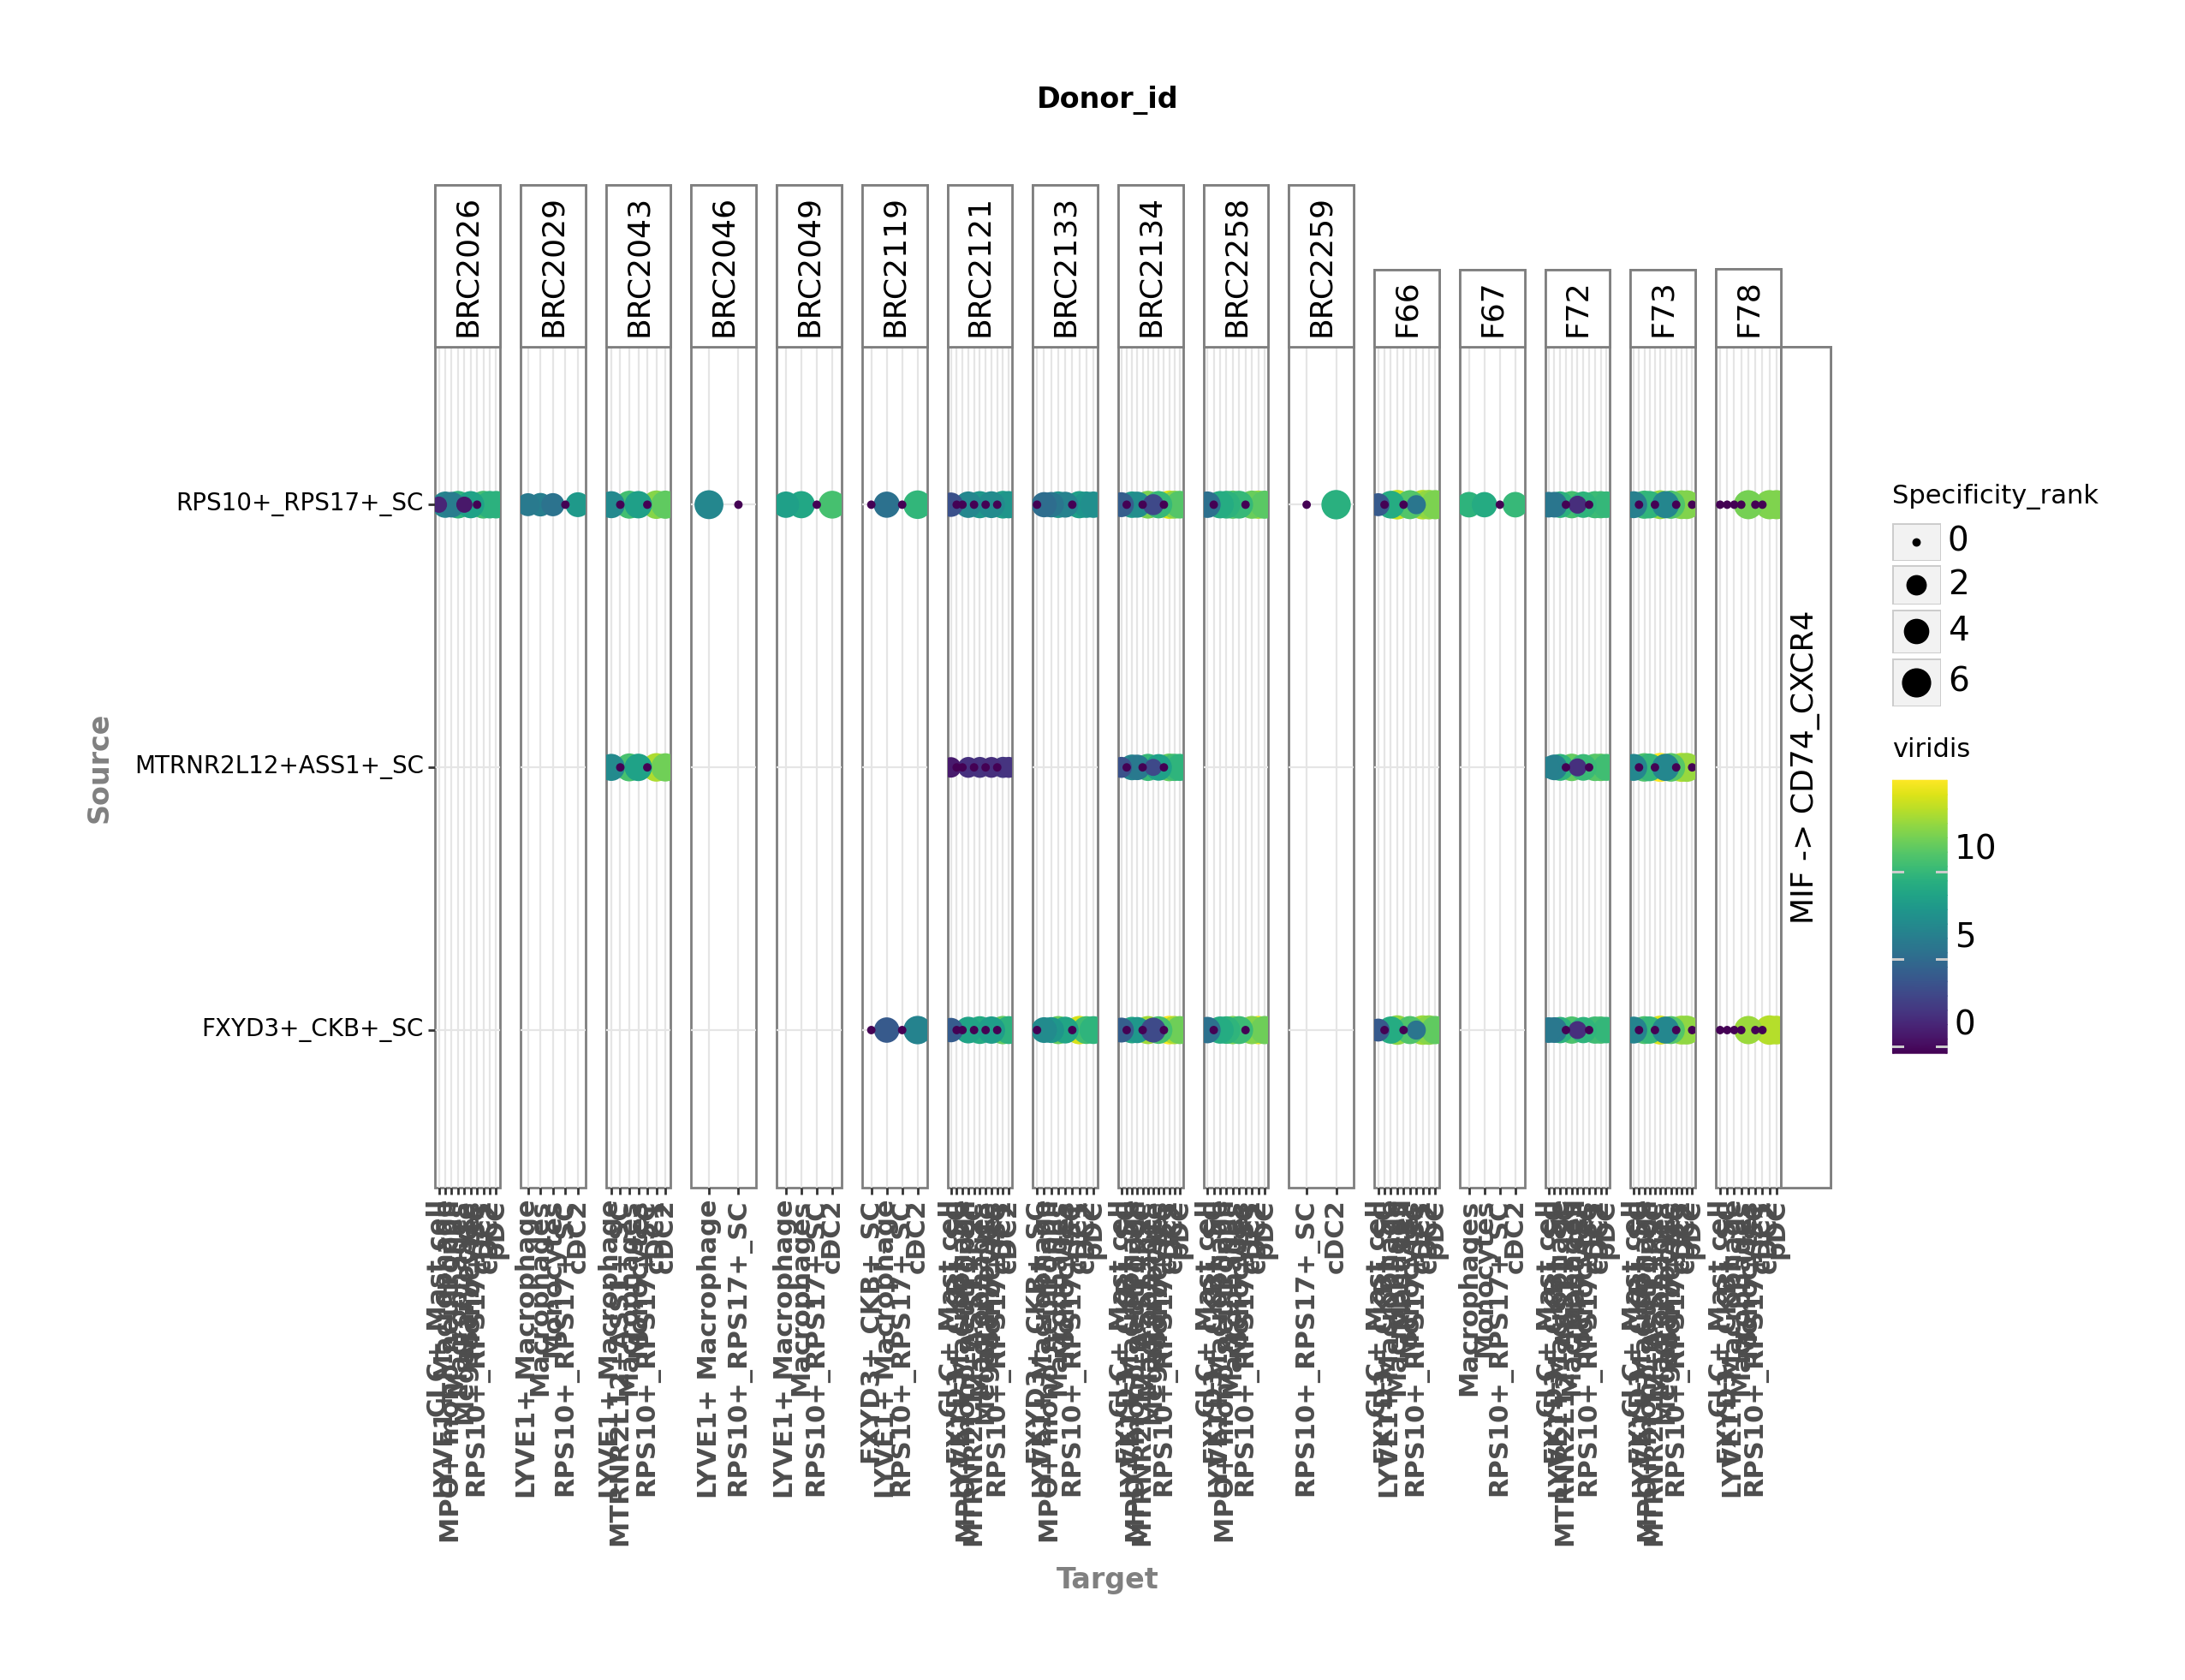

<Figure Size: (1200 x 900)>

In [43]:
plot = li.pl.dotplot_by_sample(adata=adata,
                               colour='magnitude_rank',
                               size='specificity_rank',
                               source_labels=['RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC', 'MTRNR2L12+ASS1+_SC'],
                               ligand_complex = 'MIF',
                               receptor_complex="CD74_CXCR4",
                               sample_key=sample_key,
                               inverse_colour=True,
                               inverse_size=True,
                               figure_size=(12, 9),
                               size_range=(1, 6),
                               )
plot

In [40]:
MIF_CD74_CXCR4_data

,Donor_ID,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank,signalling
15,BRC2026,RPS10+_RPS17+_SC,cDC1,MIF,CD74_CXCR4,6.831882,0.0,41.563545,0.741582,1.692140,0.025317,0.905551,0.398815,0.0,6.239935e-06,4.772758e-11,MIF-CD74_CXCR4
24,BRC2026,RPS10+_RPS17+_SC,pDC,MIF,CD74_CXCR4,6.490149,0.0,38.439354,0.641266,1.112556,0.023414,0.902156,0.382931,0.0,8.626171e-06,2.448271e-10,MIF-CD74_CXCR4
26,BRC2026,RPS10+_RPS17+_SC,Macrophages,MIF,CD74_CXCR4,6.490053,0.0,38.438469,0.641237,1.451044,0.023414,0.902155,0.385966,0.0,8.631081e-06,2.692909e-10,MIF-CD74_CXCR4
28,BRC2026,RPS10+_RPS17+_SC,cDC2,MIF,CD74_CXCR4,6.464173,0.0,38.201874,0.633640,1.228431,0.023270,0.901882,0.380763,0.0,8.849352e-06,3.230005e-10,MIF-CD74_CXCR4
49,BRC2026,RPS10+_RPS17+_SC,Monocytes,MIF,CD74_CXCR4,6.066738,0.0,34.568424,0.516973,0.684303,0.021056,0.897370,0.363378,0.0,1.303344e-05,2.699122e-09,MIF-CD74_CXCR4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007321,F78,FXYD3+_CKB+_SC,cDC2,MIF,CD74_CXCR4,7.588462,0.0,55.490604,0.654051,0.692366,0.031644,0.936785,0.453573,0.0,7.359180e-07,7.034508e-14,MIF-CD74_CXCR4
3007322,F78,FXYD3+_CKB+_SC,Monocytes,MIF,CD74_CXCR4,7.412413,0.0,53.328239,0.603286,0.205113,0.030411,0.935598,0.445054,0.0,3.260680e-06,2.374132e-13,MIF-CD74_CXCR4
3007323,F78,RPS10+_RPS17+_SC,pDC,MIF,CD74_CXCR4,7.210769,0.0,49.316410,0.545863,0.919908,0.028123,0.933201,0.443409,0.0,1.147012e-06,9.938784e-13,MIF-CD74_CXCR4
3007324,F78,RPS10+_RPS17+_SC,cDC2,MIF,CD74_CXCR4,7.304827,0.0,50.364986,0.572985,1.221798,0.028721,0.933854,0.439699,0.0,1.077255e-06,1.099122e-12,MIF-CD74_CXCR4


In [34]:
magnitude_mean = MIF_CD74_CXCR4_data['magnitude_rank'].mean()
magnitude_std = MIF_CD74_CXCR4_data['magnitude_rank'].std()

print(f"Magnitude Mean: {magnitude_mean}")
print(f"Magnitude Standard Deviation: {magnitude_std}")

Magnitude Mean: 0.0015175969860017674
Magnitude Standard Deviation: 0.010573262896638791


In [44]:
data = pd.read_csv('/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Fetal_stem_cells/FetalSC_and_other_fetal_cells/FetalSC_and_myeloid_liana_aggregated.csv')

In [49]:
data

,Unnamed: 0,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank,signalling
15,346283,FXYD3+_CKB+_SC,Macrophages,APP,CD74,6.978638,0.000,40.046803,0.969714,1.839922,0.023245,0.932486,0.360309,0.0,0.000013,1.440067e-12,APP-CD74
17,175889,FXYD3+_CKB+_SC,Lymphoid DC,APP,CD74,6.916019,0.000,39.541250,0.954828,1.160319,0.022951,0.932085,0.358489,0.0,0.000013,1.975394e-12,APP-CD74
20,630273,FXYD3+_CKB+_SC,cDC1,APP,CD74,6.918135,0.000,39.558330,0.955331,1.197614,0.022961,0.932099,0.356389,0.0,0.000013,3.004310e-12,APP-CD74
23,687071,FXYD3+_CKB+_SC,cDC2,APP,CD74,6.804831,0.000,38.643570,0.928400,1.141528,0.022430,0.931355,0.352699,0.0,0.000013,3.858155e-12,APP-CD74
25,93067,Megakaryocyte,FXYD3+_CKB+_SC,TIMP1,CD63,6.520283,0.000,42.357437,0.929605,1.518074,0.014266,0.934231,0.347418,0.0,0.000080,5.420400e-12,TIMP1-CD63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783070,782998,RPS10+_RPS17+_SC,pDC,BTN1A1,TARM1,0.000000,1.000,0.000000,-0.000337,-0.056919,0.000000,0.000000,0.000000,1.0,1.000000,1.000000e+00,BTN1A1-TARM1
783071,782999,RPS10+_RPS17+_SC,pDC,BTN1A1,NEGR1,0.028801,0.205,0.000415,0.053441,0.025979,0.017793,0.042589,0.000000,1.0,0.077365,1.000000e+00,BTN1A1-NEGR1
783072,783000,RPS10+_RPS17+_SC,pDC,WFIKKN2,IGDCC3,0.000000,1.000,0.000000,-0.028440,-0.408615,0.000000,0.000000,0.000000,1.0,1.000000,1.000000e+00,WFIKKN2-IGDCC3
783073,782987,RPS10+_RPS17+_SC,pDC,PI16,MFAP3L,0.000000,1.000,0.000000,-0.046124,-0.663725,0.000000,0.000000,0.000000,1.0,1.000000,1.000000e+00,PI16-MFAP3L


In [46]:
data = data[data['source'].isin(['MTRNR2L12+ASS1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC']) | data['target'].isin(['MTRNR2L12+ASS1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC'])]

In [48]:
data['signalling'] = data['ligand_complex'] + '-' + data['receptor_complex']

/tmp/ipykernel_1623128/939831457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [50]:
data.to_csv('/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Fetal_stem_cells/FetalSC_and_other_fetal_cells/FetalSC_and_myeloid_liana_aggregated_filtered.csv')